<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/GDF_OPS_applications/blob/main/crime.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# How is crime in this area?

It is important to know a close average of crime of a place of interest. Maybe you are a city counselor who wants to request a better way to distribute your limited police resources, but you realize official reports or surveys are too aggregated to support your decision-making.

This is a good case for areal interpolation. You know the county level of crime, but not the situation of your closer locality. Your interest is not a point; you cannot efficiently safeguard person by person. Thus, you are due to make your best estimate for a particular area where significant strategies could be deployed effective and efficiently.

## The libraries needed

We will need Pysal, openpyxl, h3, geopy, and as usual GeoPandas. I will . Make sure they are installed:

In [ ]:
# !pip show pysal openpyxl geopandas pandas h3 geopy

## The data inventory

According to what we have, we can make the best of it.

1. Counties map in Massachussetts (from [MASS.GOV](https://www.mass.gov/info-details/massgis-data-counties)):

In [2]:
mainGitHub='https://github.com/meade68/DACSS_690D_Week08/raw/refs/heads/main/'
linkCountiesMA=mainGitHub+"MASSACHUSETTS/counties_mass.zip"

import geopandas as gpd
countiesMA = gpd.read_file(linkCountiesMA)

countiesMA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 14 non-null     object  
 1   fips_id            14 non-null     int32   
 2   county             14 non-null     object  
 3   pop1980            14 non-null     int32   
 4   pop1990            14 non-null     int32   
 5   pop2000            14 non-null     int32   
 6   pop2010            14 non-null     int32   
 7   popch80_90         14 non-null     int32   
 8   popch90_00         14 non-null     int32   
 9   popch00_10         14 non-null     int32   
 10  sq_miles           14 non-null     float64 
 11  sq_km              14 non-null     float64 
 12  area_acres         14 non-null     float64 
 13  gdb_geomattr_data  0 non-null      object  
 14  geometry           14 non-null     geometry
dtypes: float64(3), geometry(1), int32(8), object(3)
mem

2. The crime per county in the USA (from [KAGGLE](https://www.kaggle.com/datasets/mikejohnsonjr/united-states-crime-rates-by-county/data))

In [3]:
import pandas as pd


linkCrimeCountyUSA=mainGitHub+"MASSACHUSETTS/crime_data_w_population_and_crime_rate.xlsx"
CrimeCountyUSA = pd.read_excel(linkCrimeCountyUSA)

CrimeCountyUSA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   county_name            3136 non-null   object 
 1   state                  3136 non-null   object 
 2   crime_rate_per_100000  3136 non-null   float64
 3   index                  3136 non-null   int64  
 4   EDITION                3136 non-null   int64  
 5   PART                   3136 non-null   int64  
 6   IDNO                   3136 non-null   int64  
 7   CPOPARST               3136 non-null   int64  
 8   CPOPCRIM               3136 non-null   int64  
 9   AG_ARRST               3136 non-null   int64  
 10  AG_OFF                 3136 non-null   int64  
 11  COVIND                 3136 non-null   float64
 12  INDEX                  3136 non-null   int64  
 13  MODINDX                3136 non-null   int64  
 14  MURDER                 3136 non-null   int64  
 15  RAPE

3. The map of municipalities of MA ([MAP-GIS](https://www.mass.gov/info-details/massgis-data-municipalities))

In [4]:
linkMunsMA=mainGitHub+"MASSACHUSETTS/municipalities.zip"

import geopandas as gpd
MunsMA = gpd.read_file(linkMunsMA)

MunsMA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 351 non-null    object  
 1   town               351 non-null    object  
 2   town_id            351 non-null    int32   
 3   type               351 non-null    object  
 4   county             351 non-null    object  
 5   fips_stco          351 non-null    int32   
 6   fourcolor          351 non-null    int32   
 7   pop1960            351 non-null    int32   
 8   pop1970            351 non-null    int32   
 9   pop1980            351 non-null    int32   
 10  pop1990            351 non-null    int32   
 11  pop2000            351 non-null    int32   
 12  pop2010            351 non-null    int32   
 13  pop2020            351 non-null    int32   
 14  popch10_20         351 non-null    int32   
 15  area_acres         351 non-null    float64 
 16  

## Preprocessing the "source" and "target"

Areal interpolation is a technique that estimates data values for a set of target zones by redistributing known values from a different set of overlapping source zones. The goal is to obtain estimates for unknown values at the TARGET level based on the known counts at the SOURCE level.

This requires some preprocessing:

1. Establish a **Consistent, Projected CRS**. All GeoDataFrames must share the same projected CRS (e.g., EPSG:3857, UTM, or a local Equal-Area projection) to ensure that geometric calculations like area overlap and feature intersection are accurate and not distorted by latitude/longitude measurements.
2. Ensure **Geometric Alignment**. Confirm that the source and target boundaries are geometrically clean (no self-intersections or gaps) and that the target units perfectly tile the source units where data is to be estimated.
3. **The source map should have the variable of interest**. The crime data is not yet there, it is in a different file; we need to merge the crime data from a DataFrame into the counties GeoDataFrame. If you have population data, keep it.


In all cases, give a good format to column names so they are self-descriptive.
   

### The CRS

Let's confirm the are projected, and share the same crs:

In [5]:
countiesMA.crs.to_epsg(), MunsMA.crs.to_epsg(), MunsMA.crs.is_projected

(26986, 26986, True)

The crs '26986' is an adequate projection, provides the necessary local accuracy and area preservation required to run interpolation in Massachusetts.

### The Alignment of Target GDF

Let's verify we have the same amount of counties:

In [12]:
len(set(MunsMA.fips_stco)), len(set(countiesMA.fips_id))

(14, 14)

So the count is ok.

Let me verify alignment between both GDFs. If we dissolve the municipalities/towns by county - the union of this GDF with the countiesMA GDF should have the same amount of rows (14)

In [13]:
countiesMA.overlay(MunsMA.dissolve(by='county'),keep_geom_type=True,how='union').shape

(35, 32)

We have 35 polygons. We expected 14. The smart solution is to use the municipalities themselves to build up the counties.  Let's see how MunsMA can serve for the counties map:

In [14]:
countiesMA_source=MunsMA.dissolve(by='fips_stco',as_index=False)

keep=['fips_stco','geometry']
countiesMA_source=countiesMA_source[keep]
countiesMA_source.rename(columns={'fips_stco':'fips_id'},inplace=True)

# here
countiesMA_source.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   fips_id   14 non-null     int32   
 1   geometry  14 non-null     geometry
dtypes: geometry(1), int32(1)
memory usage: 300.0 bytes


This should give 14:

In [ ]:
countiesMA_source.overlay(MunsMA.dissolve(by='county'),keep_geom_type=True,how='union').shape

Now we are sure both county and municipality maps align.

### The Target map

The municipalities map is our target. Let's just keep what may be needed:

In [15]:
keep=['town','county','fips_stco','pop2020','geometry']
municipalitiesMA_target=MunsMA[keep].copy()
municipalitiesMA_target.rename(columns={'fips_stco':'fips_id'},inplace=True)
municipalitiesMA_target

,town,county,fips_id,pop2020,geometry
0,LEYDEN,FRANKLIN,25011,734,"POLYGON ((110027.553 942832.065, 110708.203 93..."
1,HUDSON,MIDDLESEX,25017,20092,"POLYGON ((197690.773 905668.345, 197791.653 90..."
2,WESTWOOD,NORFOLK,25021,16266,"POLYGON ((227514.413 885958.825, 229226.782 88..."
3,HOLLAND,HAMPDEN,25013,2603,"POLYGON ((147457.513 871335.125, 147357.562 86..."
4,NORWOOD,NORFOLK,25021,31611,"POLYGON ((225443.469 884850.765, 225573.992 88..."
...,...,...,...,...,...
346,NORTHBRIDGE,WORCESTER,25027,16335,"POLYGON ((188252.282 879479.415, 191146.102 87..."
347,EASTHAMPTON,HAMPSHIRE,25015,16211,"POLYGON ((103344.752 893965.825, 104317.992 89..."
348,NORTH ANDOVER,ESSEX,25009,30915,"POLYGON ((232049.362 942816.125, 233051.542 94..."
349,NORTON,BRISTOL,25005,19202,"POLYGON ((233072.343 860388.955, 231021.932 85..."


### The Merging

We will merge **CrimeCountyUSA**  DF into **crimeMA** GDF.

Let's check the county names, which is the key for merging DF into GDF:

In [16]:
CrimeCountyUSA.head(2)

,county_name,state,crime_rate_per_100000,index,EDITION,PART,IDNO,CPOPARST,CPOPCRIM,AG_ARRST,...,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,MVTHEFT,ARSON,population,FIPS_ST,FIPS_CTY
0,Los Angeles County,CA,444.800814,397,1,4,206,9980757,9980757,108,...,1976,18923,23057,49107,142604,40555,2210,10017068,6,37
1,Harris County,TX,696.103834,94,1,4,2651,4272223,4243516,42,...,1143,12449,16290,43644,114208,20829,1153,4336853,48,201


The DF _CrimeCountyUSA_ has different county names than the _countiesMA_source_. But both have some "fips" information. _CrimeCountyUSA_ has 'FIPS_ST' and 'FIPS_CTY' which will help us build a column exactly as *fips_id* in countiesMA GDF.

Let's create 'fips_id' in a copy of the CrimeCountyUSA. Let's also keep some columns.

In [21]:
# just a copy
crimeMA=CrimeCountyUSA.copy()

# adding a column 'fips_id'
crimeMA=crimeMA.assign(fips_id=crimeMA.FIPS_ST*1000+crimeMA.FIPS_CTY)

# subetting crimeMA
keep=['county_name','fips_id','population','BURGLRY','AGASSLT']
crimeMA=crimeMA[keep]

# renaming
crimeMA.rename(columns={'AGASSLT':'AG_ASSLT'},inplace=True)

# see
crimeMA.head()

,county_name,fips_id,population,BURGLRY,AG_ASSLT
0,Los Angeles County,6037,10017068,49107,23057
1,Harris County,48201,4336853,43644,16290
2,Cook County,17031,5240700,34233,14657
3,Maricopa County,4013,4009412,32859,9810
4,Dallas County,48113,2480331,25141,5227


#### Extensive and Intensive values

Counts are extensive values. The crimes we selected are currently of the extensive kind. We could think of creating an intensive variable by normalizing those counts by the county population (remember Choropleths use these kind of variables):

In [18]:
crimeMA['BURGLRY_rate10K']=10000*crimeMA.BURGLRY/crimeMA.population
crimeMA['AG_ASSLT_rate10K']=10000*crimeMA.AG_ASSLT/crimeMA.population

The merge would be easy now:

In [19]:
# merge by "fips_id"
countiesMA_source=countiesMA_source.merge(crimeMA)

Our source GDF is ready:

In [20]:
countiesMA_source.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   fips_id           14 non-null     int32   
 1   geometry          14 non-null     geometry
 2   county_name       14 non-null     object  
 3   population        14 non-null     int64   
 4   BURGLRY           14 non-null     int64   
 5   AG_ASSLT          14 non-null     int64   
 6   BURGLRY_rate10K   14 non-null     float64 
 7   AG_ASSLT_rate10K  14 non-null     float64 
dtypes: float64(2), geometry(1), int32(1), int64(3), object(1)
memory usage: 972.0+ bytes


## Option 1: Areal interpolation

Areal interpolation is the simplest way to move data from one set of large boundary areas to a new set of smaller boundary areas, contained in the large one.

Imagine you have crime data for entire counties (your source areas), but you need to know the crime rate for city limits (your target areas).

The simplest version of areal interpolation is the "Area-Weighted" method:

Overlap: You figure out how much of the old area (County A) overlaps the new area (City 1).

Proportion: If 25% of County A's area covers City 1, you assign 25% of County A's total crime count to City 1.

It's a straightforward geographical averaging—it assumes the crime is spread evenly across the entire source area. This often leads to inaccurate estimates, but it's a quick, easy baseline for transferring data between incompatible maps.

Let' use tobler(area_weighted) library's **area_interpolate**. Notice we can interpolate extensice and intensive variables.

In [22]:
from tobler.area_weighted  import area_interpolate as interpolate

myExtensive=['AG_ASSLT','BURGLRY']
myIntensive=['AG_ASSLT_rate10K','BURGLRY_rate10K']

municipalitiesMA_target.set_index('fips_id',inplace=True)


areal_municipalities = interpolate(
    source_df=countiesMA_source,
    target_df=municipalitiesMA_target,
    extensive_variables=myExtensive,
    intensive_variables=myIntensive
)

This the resulting GDF (interpolated):

In [23]:
areal_municipalities

,AG_ASSLT,BURGLRY,AG_ASSLT_rate10K,BURGLRY_rate10K,geometry
fips_id,,,,,
25011,4.486106,12.062639,25.273443,67.957480,"POLYGON ((110027.553 942832.065, 110708.203 93..."
25017,31.886736,72.617661,14.650933,33.365488,"POLYGON ((197690.773 905668.345, 197791.653 90..."
25021,24.438521,58.843591,13.012465,31.331690,"POLYGON ((227514.413 885958.825, 229226.782 88..."
25013,36.549520,94.049158,38.004019,97.791872,"POLYGON ((147457.513 871335.125, 147357.562 86..."
25021,23.056417,55.515731,13.012466,31.331691,"POLYGON ((225443.469 884850.765, 225573.992 88..."
...,...,...,...,...,...
25027,30.462052,54.077286,32.937588,58.471943,"POLYGON ((188252.282 879479.415, 191146.102 87..."
25015,7.012080,16.145252,17.606958,40.539863,"POLYGON ((103344.752 893965.825, 104317.992 89..."
25009,115.488338,158.269799,28.037506,38.423710,"POLYGON ((232049.362 942816.125, 233051.542 94..."


This is a new GDF. Here, you have the variables for each of the municipalities.

### Concatenating aereal interpolation to Target

These new columns will be concatenated (added) to the municipalities. Let's prepare the concatenation:

1. Drop the geometry column: once concatenated

In [25]:
areal_municipalities.drop(columns='geometry',inplace=True)

2. Rename the columns, so as to inform the process:

In [26]:
# current columns names
areal_municipalities.columns

Index(['AG_ASSLT', 'BURGLRY', 'AG_ASSLT_rate10K', 'BURGLRY_rate10K'], dtype='object')

In [27]:
# new names
[name+'_aereal' for name in areal_municipalities.columns]

['AG_ASSLT_aereal',
 'BURGLRY_aereal',
 'AG_ASSLT_rate10K_aereal',
 'BURGLRY_rate10K_aereal']

In [28]:
# dict of renaming
old=areal_municipalities.columns
new=[name+'_aereal' for name in areal_municipalities.columns]
fromOldToNew_dict={o:n for o,n in zip(old,new)}
fromOldToNew_dict


{'AG_ASSLT': 'AG_ASSLT_aereal',
 'BURGLRY': 'BURGLRY_aereal',
 'AG_ASSLT_rate10K': 'AG_ASSLT_rate10K_aereal',
 'BURGLRY_rate10K': 'BURGLRY_rate10K_aereal'}

In [29]:
# renaming
areal_municipalities.rename(columns=fromOldToNew_dict,inplace=True)

Now, we can simply concatenate both:

In [30]:
toConcatenate=[municipalitiesMA_target, areal_municipalities]

municipalitiesMA_interpolated=pd.concat(toConcatenate,axis=1)

# here it is
municipalitiesMA_interpolated


,town,county,pop2020,geometry,AG_ASSLT_aereal,BURGLRY_aereal,AG_ASSLT_rate10K_aereal,BURGLRY_rate10K_aereal
fips_id,,,,,,,,
25011,LEYDEN,FRANKLIN,734,"POLYGON ((110027.553 942832.065, 110708.203 93...",4.486106,12.062639,25.273443,67.957480
25017,HUDSON,MIDDLESEX,20092,"POLYGON ((197690.773 905668.345, 197791.653 90...",31.886736,72.617661,14.650933,33.365488
25021,WESTWOOD,NORFOLK,16266,"POLYGON ((227514.413 885958.825, 229226.782 88...",24.438521,58.843591,13.012465,31.331690
25013,HOLLAND,HAMPDEN,2603,"POLYGON ((147457.513 871335.125, 147357.562 86...",36.549520,94.049158,38.004019,97.791872
25021,NORWOOD,NORFOLK,31611,"POLYGON ((225443.469 884850.765, 225573.992 88...",23.056417,55.515731,13.012466,31.331691
...,...,...,...,...,...,...,...,...
25027,NORTHBRIDGE,WORCESTER,16335,"POLYGON ((188252.282 879479.415, 191146.102 87...",30.462052,54.077286,32.937588,58.471943
25015,EASTHAMPTON,HAMPSHIRE,16211,"POLYGON ((103344.752 893965.825, 104317.992 89...",7.012080,16.145252,17.606958,40.539863
25009,NORTH ANDOVER,ESSEX,30915,"POLYGON ((232049.362 942816.125, 233051.542 94...",115.488338,158.269799,28.037506,38.423710


### Plotting comparatively

Let's see the aggravated assault results comparatively, let's start with crime counts:

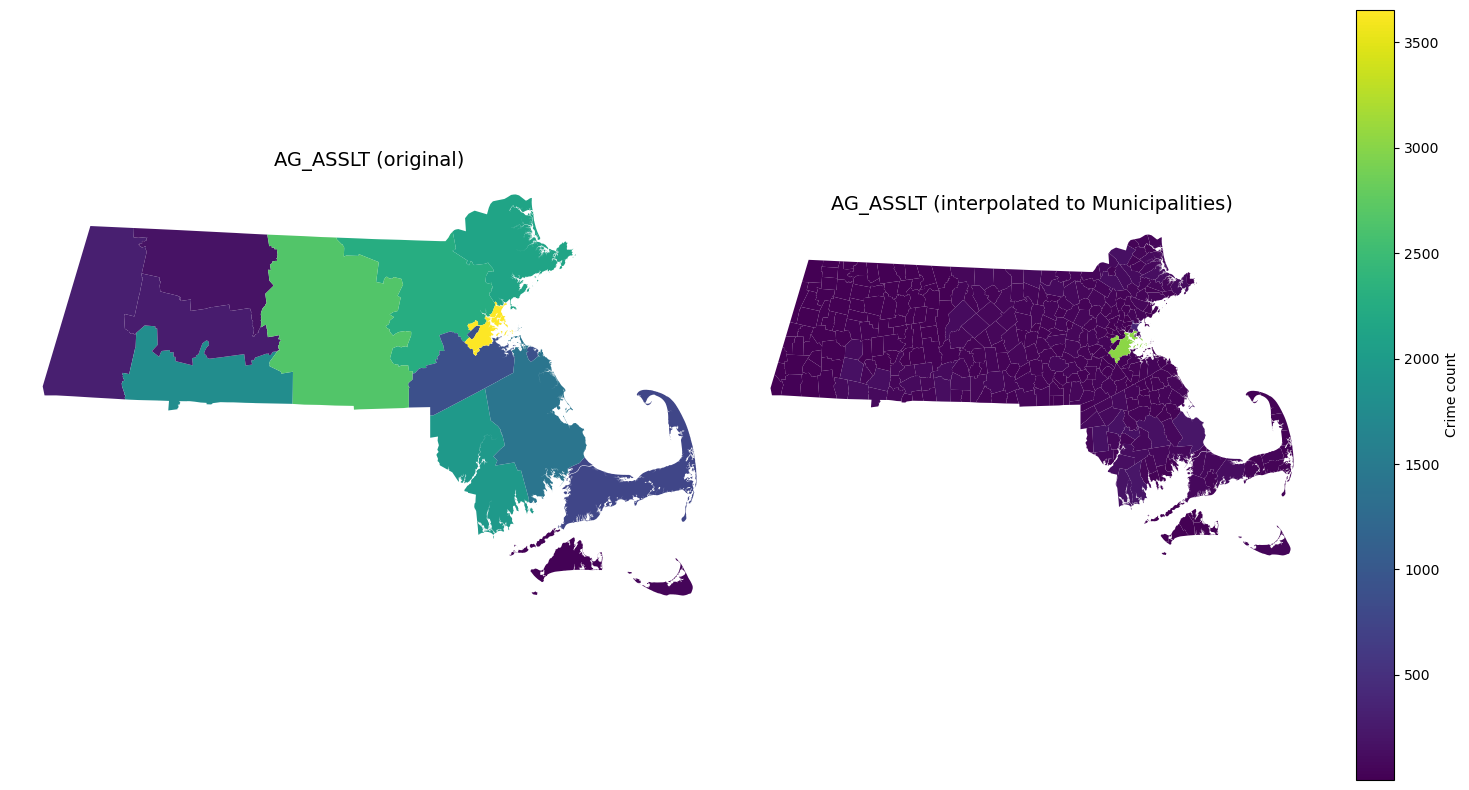

In [31]:
import matplotlib.pyplot as plt

# Find the absolute minimum and maximum rate across both datasets
count_min = min(countiesMA_source['AG_ASSLT'].min(), municipalitiesMA_interpolated['AG_ASSLT_aereal'].min())
count_max = max(countiesMA_source['AG_ASSLT'].max(), municipalitiesMA_interpolated['AG_ASSLT_aereal'].max())

# let's create a dict with common parameters
dictParams=dict(linewidth=0.8,legend_kwds={'label': "Crime count"},
                cmap='viridis',
                vmin=count_min,              # Ensures the color scale starts at the global min
                vmax=count_max)              # Ensures the color scale ends at the global max

fig, axes = plt.subplots(1, 2, figsize=(15, 8))


# --- MAP 1
countiesMA_source.plot(column='AG_ASSLT',ax=axes[0],**dictParams,legend=False)
axes[0].set_title('AG_ASSLT (original)', fontsize=14)
axes[0].set_axis_off()


# --- MAP 2
municipalitiesMA_interpolated.plot(column='AG_ASSLT_aereal',ax=axes[1],**dictParams,legend=True)
axes[1].set_title('AG_ASSLT (interpolated to Municipalities)', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

Now, crime rates:

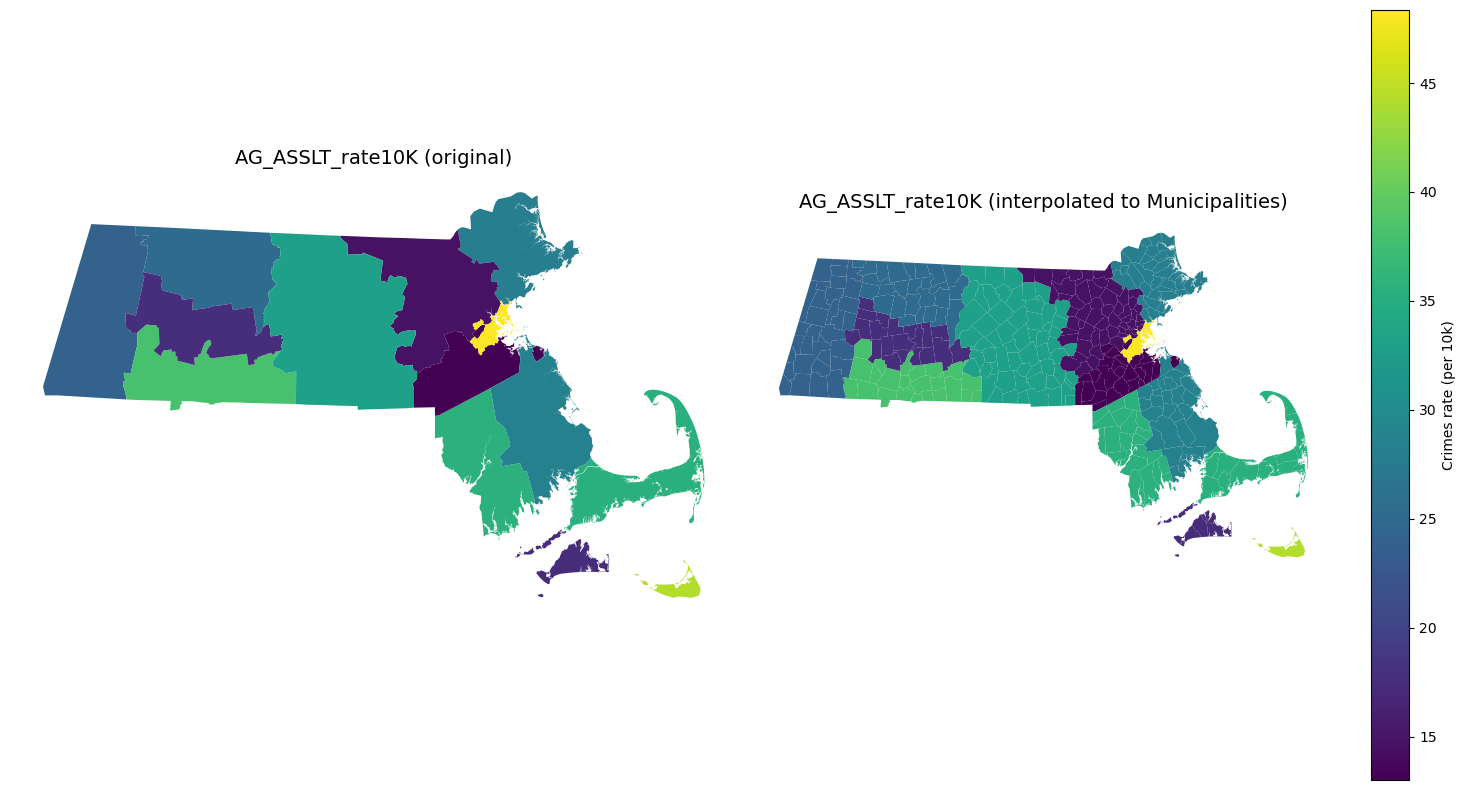

In [32]:
rate_min = min(countiesMA_source['AG_ASSLT_rate10K'].min(), municipalitiesMA_interpolated['AG_ASSLT_rate10K_aereal'].min())
rate_max = max(countiesMA_source['AG_ASSLT_rate10K'].max(), municipalitiesMA_interpolated['AG_ASSLT_rate10K_aereal'].max())

dictParams=dict(linewidth=0.8,legend_kwds={'label': "Crimes rate (per 10k)"},
                vmin=rate_min, vmax=rate_max)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# --- MAP 1:
countiesMA_source.plot(column='AG_ASSLT_rate10K',ax=axes[0],**dictParams,legend=False)
axes[0].set_title('AG_ASSLT_rate10K (original)', fontsize=14)
axes[0].set_axis_off()


# --- MAP 2:
municipalitiesMA_interpolated.plot(column='AG_ASSLT_rate10K_aereal',ax=axes[1],**dictParams,legend=True)
axes[1].set_title('AG_ASSLT_rate10K (interpolated to Municipalities)', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

## Option 2: Dasymetric Interpolation

Dasymetric interpolation is a smarter way to transfer data from large areas to smaller ones by using auxiliary data to guide the process. Instead of assuming data is spread evenly (like simple Areal Interpolation), Dasymetric methods assume the data follows a pattern dictated by a secondary map.

The term "dasymetric" comes from Greek roots meaning "dense measurement" or "distribution measurement."

How It Works?

Here we're moving a county's crime  to municipal aereas.

Auxiliary Map: You use a secondary, fine-grained map—like land-use pixels (forest, urban, water, etc.)—as the guide.

Weighted Transfer: Instead of dividing the crime based on the city's total area, you divide it based on the area of "relevant" land use within that block. In our case, the more 'urban' area.

If 90% of a county's crime is shown by a model to occur on urban land, the model only places crime on the urban pixels within the city, leaving forest and water areas with a zero crime estimate.

Why It's Better?

Dasymetric interpolation creates a much denser and more accurate map because it respects the underlying geographical reality. The resulting small areas aren't just averages; they are informed predictions based on where the activity is known to occur.

The auxiliary map with pixel information is a **raster** map. We will a raster that comes from [GHSL - Global Human Settlement Layer](https://human-settlement.emergency.copernicus.eu/download.php?ds=smod). As you read the documentation they will tell the values the cells represent.

- Class 30: “Urban Centre grid cell”
- Class 23: “Dense Urban Cluster grid cell”
- Class 22: “Semi-dense Urban Cluster grid cell”
- Class 21: “Suburban or per-urban grid cell”
- Class 13: “Rural cluster grid cell”
- Class 12: “Low Density Rural grid cell”
- Class 11: “Very low density rural grid cell”
- Class 10: “Water grid cell”(not populated nor built).

For crime distribution, we'll focus on populated urban areas (classes 21-30) since crimes predominantly occur where people live and work, while excluding rural and water areas.

In [51]:
from tobler.dasymetric import masked_area_interpolate as dasy

rasterPath=mainGitHub+"WORLD/raster/GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V2_0.tif"
populatedCodes=[21,22,23,30]


dasymetric_municipalities=dasy(
    source_df=countiesMA_source,
    target_df=municipalitiesMA_target,
    raster=rasterPath,
    pixel_values=populatedCodes,
    extensive_variables=myExtensive,
    intensive_variables=myIntensive
)

RasterioIOError: HTTP response code: 404

Here we are:

In [ ]:
dasymetric_municipalities

### Concatenating Dasymetric interpolation to Target

Given we have the same structure, let's follow the same steps to **concatenate** this results into **municipalitiesMA_interpolated**:

In [ ]:
# bye column
dasymetric_municipalities.drop(columns='geometry',inplace=True)

# renaming
old=dasymetric_municipalities.columns
new=[name+'_dasy' for name in dasymetric_municipalities.columns]
fromOldToNew_dict={o:n for o,n in zip(old,new)}
dasymetric_municipalities.rename(columns=fromOldToNew_dict,inplace=True)

# concatenating
toConcatenate=[municipalitiesMA_interpolated, dasymetric_municipalities] #notice this

# self concat
municipalitiesMA_interpolated=pd.concat(toConcatenate,axis=1)

# here it is
municipalitiesMA_interpolated

### Plotting comparatively

Let's see the burglary results comparatively, let's start with crime counts:

In [ ]:
# common min and max
count_min = min(countiesMA_source['BURGLRY'].min(),
                municipalitiesMA_interpolated['BURGLRY_aereal'].min(),
                municipalitiesMA_interpolated['BURGLRY_dasy'].min()
               )
count_max = max(countiesMA_source['AG_ASSLT'].max(),
                municipalitiesMA_interpolated['AG_ASSLT_aereal'].max(),
                municipalitiesMA_interpolated['BURGLRY_dasy'].max()
               )

# dict with common parameters
dictParams=dict(linewidth=0.8,    legend_kwds={'label': "Crime count",'orientation': "horizontal"},
                cmap='viridis',  vmin=count_min,  vmax=count_max)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))


# --- MAP 1
countiesMA_source.plot(column='BURGLRY',ax=axes[0],**dictParams,legend=False)
axes[0].set_title('BURGLARY (original)', fontsize=14)
axes[0].set_axis_off()


# --- MAP 2
municipalitiesMA_interpolated.plot(column='BURGLRY_aereal',ax=axes[1],**dictParams,legend=True)
axes[1].set_title('BURGLARY (interpolated to Municipalities)', fontsize=14)
axes[1].set_axis_off()


# --- MAP 3
municipalitiesMA_interpolated.plot(column='BURGLRY_dasy',ax=axes[2],**dictParams,legend=False)
axes[2].set_title('BURGLARY (interpolated (Dasymetric) to Municipalities)', fontsize=14)
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# common min and max
count_min = min(countiesMA_source['BURGLRY_rate10K'].min(),
                municipalitiesMA_interpolated['BURGLRY_rate10K_aereal'].min(),
                municipalitiesMA_interpolated['BURGLRY_rate10K_dasy'].min()
               )
count_max = max(countiesMA_source['BURGLRY_rate10K'].max(),
                municipalitiesMA_interpolated['BURGLRY_rate10K_aereal'].max(),
                municipalitiesMA_interpolated['BURGLRY_rate10K_dasy'].max()
               )

# dict with common parameters
dictParams=dict(linewidth=0.8, legend_kwds={'label': "Crime rate (10k)",'orientation': "horizontal"},
                cmap='viridis', vmin=count_min,vmax=count_max)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))


# --- MAP 1
countiesMA_source.plot(column='BURGLRY_rate10K',ax=axes[0],legend=False,**dictParams)
axes[0].set_title('BURGLARY Rate \n(original)', fontsize=14)
axes[0].set_axis_off()


# --- MAP 2
municipalitiesMA_interpolated.plot(column='BURGLRY_rate10K_aereal',ax=axes[1],legend=True,**dictParams)
axes[1].set_title('BURGLRY Rate \n(interpolated to Municipalities)', fontsize=14)
axes[1].set_axis_off()


# --- MAP 3
municipalitiesMA_interpolated.plot(column='BURGLRY_rate10K_dasy',ax=axes[2],legend=False,**dictParams)
axes[2].set_title('BURGLRY Rate \n(interpolated (Dasymetric) to Municipalities)', fontsize=14)
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

## Option 3: Dasymetric using H3 grid

Dasymetric Interpolation using an H3 Grid is the method for getting the most precise, street-level view of your data. It takes the Smart Dasymetric approach (Option 2) and applies it to very tiny, uniform target areas.

How It Works?

**Tiny Targets**: Instead of using administrative boundaries like cities or blocks, you use a global grid of perfect hexagons called H3 cells . These hexagons are the same size everywhere and can be very small (like a few city blocks).

**Same Smart Model**: You take the same spatial weights (the land-use influence: "urban land attracts this much crime") determined by your Dasymetric model.

**Maximum Detail**: You apply those weights to the land-use pixels found inside each tiny H3 hexagon.

This tells you the predicted crime rate for that specific hexagon.

Why It's the Best for Decisions?

The result is an extremely granular map that shows you exactly where the rate is high or low, block-by-block. This level of detail is perfect for practical applications like evaluating the risk for a single property address, making it the ideal tool for your final buying/renting decision.

Let's inspect the smallest municipality area:

In [ ]:
municipalitiesMA_target.area.min()/ 1000000

The smallest municipality is a little bigger than 3 km2, notice some resolutions offered by H3 grid:

### Resolution Comparison


| H3 Resolution | Approximate Area per Hexagon |
|---------------|------------------------------|
| 10            | ∼0.008 km²                   |
| 9             | ∼0.11 km²                    |
| 8             | ∼0.73 km²                    |

SO, the smallees of our municipalities will be represented by:

In [ ]:
(municipalitiesMA_target.area.min()/ 1000000)/0.73

Let's creta a **MA_grid8_target**. Remember that H3 requires geographic coordinates (EPSG:4326) to create the global grid, so we temporarily convert our data, create the hexagons, then convert back to our working projection

In [ ]:
from tobler.util import h3fy as h3

MA_grid8_target=h3(municipalitiesMA_target.to_crs(4326), resolution=8).to_crs(municipalitiesMA_target.crs)

He have this:

In [ ]:
MA_grid8_target

A little change to previous model, no more municipality as target:

In [ ]:
dasymetric_h3_grid8=dasy(
    source_df=countiesMA_source,
    target_df=MA_grid8_target,
    raster=rasterPath,
    pixel_values=populatedCodes,
    extensive_variables=myExtensive,
    intensive_variables=myIntensive
)

In [ ]:
dasymetric_h3_grid8.columns

We can not concatenate this results as before, they do not match the municipality boundaries:

In [ ]:
# COMMON MIN AND MAX ACROSS ALL THREE DATASETS
# We now use the rate from the H3 grid instead of the Aereal rate column.
count_min = min(
    countiesMA_source['BURGLRY_rate10K'].min(),
    municipalitiesMA_interpolated['BURGLRY_rate10K_dasy'].min(),
    dasymetric_h3_grid8['BURGLRY_rate10K'].min() # Using the new H3 rate column
)
count_max = max(
    countiesMA_source['BURGLRY_rate10K'].max(),
    municipalitiesMA_interpolated['BURGLRY_rate10K_dasy'].max(),
    dasymetric_h3_grid8['BURGLRY_rate10K'].max() # Using the new H3 rate column
)

# DICT WITH COMMON PARAMETERS
dictParams=dict(linewidth=0.8, legend_kwds={'label': "Crime rate (10k)",'orientation': "horizontal"},
                cmap='inferno_r', # another color map
                vmin=count_min,vmax=count_max)


# 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# --- MAP 1
countiesMA_source.plot(column='BURGLRY_rate10K',ax=axes[0],**dictParams,legend=False)
axes[0].set_title('1. BURGLARY Rate \n(Original County Rate)', fontsize=14)
axes[0].set_axis_off()

# --- MAP 2
municipalitiesMA_interpolated.plot(column='BURGLRY_rate10K_dasy',ax=axes[1],**dictParams,legend=True)
axes[1].set_title('2. BURGLARY Rate \n(Dasymetric to Municipalities)', fontsize=14)
axes[1].set_axis_off()

# --- MAP 3
# This replaces the Areal map and shows the final, highest-resolution result.
dasymetric_h3_grid8.plot(column='BURGLRY_rate10K', ax=axes[2],**dictParams,legend=False)
axes[2].set_title('3. BURGLARY Rate\n(Dasymetric to H3 Grid R8)', fontsize=14)
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

## So, what decision should I make?

Let's explore the results statistically:

In [ ]:
dasymetric_h3_grid8[['BURGLRY_rate10K','AG_ASSLT_rate10K']].describe()

Given these values, we should bin these columns. Let's use Fisher-Jenks (also called "natural breaks") for this skewed crime data because:

- Right-skewed distribution: Most hexagons have zero/low crime, few have very high values

- Natural clustering: Finds inherent groupings in the data rather than arbitrary equal intervals

- Optimal for skewed data: Minimizes variance within classes, maximizes between classes

- Preserves patterns: Better reveals the actual risk clusters in our spatial data

Unlike quantiles (which would force equal counts) or equal intervals (which would misrepresent the distribution), Fisher-Jenks adapts to our data's natural structure.

In [ ]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

K=3
theVar1=dasymetric_h3_grid8['BURGLRY_rate10K']

# based on similarity, good for skewed data
fj_burg = mapclassify.FisherJenks(theVar1, k=K)
pd.Series(fj_burg.yb).value_counts().sort_index()

In [ ]:
theVar2=dasymetric_h3_grid8['AG_ASSLT_rate10K']

# based on similarity, good for skewed data
fj_asslt = mapclassify.FisherJenks(theVar2, k=K)
pd.Series(fj_asslt.yb).value_counts().sort_index()

Notice that the bin '0' represents the hexagons with ZERO value:

In [ ]:
(dasymetric_h3_grid8['BURGLRY_rate10K']==0).sum(),(dasymetric_h3_grid8['AG_ASSLT_rate10K']==0).sum()

Then, we could rename the values computed:

In [ ]:
# renaming
newLabelsForLevels={0:"0_NoRisk", 1:"1_MediumRisk", 2:"2_HighRisk"}


dasymetric_h3_grid8['BURGLRY_rate10K_bin']=fj_burg.yb
dasymetric_h3_grid8.replace({'BURGLRY_rate10K_bin':newLabelsForLevels},inplace=True)

dasymetric_h3_grid8['AG_ASSLT_rate10K_bin']=fj_asslt.yb
dasymetric_h3_grid8.replace({'AG_ASSLT_rate10K_bin':newLabelsForLevels},inplace=True)


This is the result:

In [ ]:
dasymetric_h3_grid8

This is the location address, here we geocode:

In [ ]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point

EstateOnSale='82 Sunset Dr, Taunton, MA 02780'

geolocator = Nominatim(user_agent="theGeocoder")

EstateOnSale_Address = geolocator.geocode(EstateOnSale)

EstateOnSale_Address_gdf4326 = gpd.GeoDataFrame(
    {'address': [EstateOnSale_Address.address]},
    geometry=[Point(EstateOnSale_Address.longitude, EstateOnSale_Address.latitude)],
    crs="EPSG:4326" # because of lon/lat
)

# reprojecting
EstateOnSale_Address_gdf = EstateOnSale_Address_gdf4326.to_crs(countiesMA.crs)

# here it is
EstateOnSale_Address_gdf

Let's plot this result:

In [ ]:

# DICT WITH COMMON PARAMETERS
dictParams=dict(linewidth=0.8, cmap='inferno_r',categorical=True,figsize=(10,10))


base=dasymetric_h3_grid8.plot(column='BURGLRY_rate10K_bin', **dictParams,legend=True)
EstateOnSale_Address_gdf.plot(color='red',ax=base)

In [ ]:
# DICT WITH COMMON PARAMETERS
dictParams=dict(linewidth=0.8, cmap='inferno_r',categorical=True,figsize=(10,10))


base=dasymetric_h3_grid8.plot(column='AG_ASSLT_rate10K_bin', **dictParams,legend=True)
EstateOnSale_Address_gdf.plot(color='red',ax=base)

You can see more details, that tell us not to buy!

In [ ]:
EstateOnSale_Address_gdf.sjoin(
    dasymetric_h3_grid8,
    how="left",
    predicate="within"
)

______

[BACK TO MAIN MENU](https://dacss-spatial.github.io/GDF_OPS_applications/)